## Import dataset

In [1]:
import pandas as pd

data = pd.read_csv('data/prepared_data.csv')

## Preprocess data

In [2]:
import re

def preprocess(s):
    sentence = re.sub(r'[^a-zA-Z]', ' ', s)
    sentence = re.sub(r'\s+[a-zA-Z\s+]', ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

X = []
sentences = list(data['text'])
for s in sentences:
    X.append(preprocess(s))

y = data['rating']

## Encode and Categorize Labels

In [3]:
from sklearn import preprocessing
from keras.utils import to_categorical

encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

y = to_categorical(y)

Using TensorFlow backend.


## Split data into Training and Test sets

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Create Word Embeddings

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from numpy import asarray, zeros

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

glove_file = open('data/glove.6B.100d.txt', encoding="utf8")

embedding_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector = asarray(records[1:], dtype='float32')
    embedding_dictionary[word] = vector
glove_file.close()

vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vector = embedding_dictionary.get(word)
    if vector is not None:
        embedding_matrix[index] = vector

## Create the model

In [6]:
from keras.layers import Input, LSTM
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense
from keras.models import Model

deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)

LSTM_layer = LSTM(128)(embedding_layer)

dense_layer = Dense(3, activation='softmax')(LSTM_layer)

model = Model(inputs=deep_inputs, outputs=dense_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          2260100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,377,735
Trainable params: 117,635
Non-trainable params: 2,260,100
_________________________________________________________________
None


## Train the model

In [8]:
trained_model = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Train on 6400 samples, validate on 1600 samples
Epoch 1/10
6400/6400 [==============================] - 28s 4ms/step - loss: 0.8637 - acc: 0.6692 - val_loss: 0.7807 - val_acc: 0.6931
Epoch 2/10
6400/6400 [==============================] - 26s 4ms/step - loss: 0.8027 - acc: 0.6798 - val_loss: 0.7806 - val_acc: 0.6931
Epoch 3/10
6400/6400 [==============================] - 26s 4ms/step - loss: 0.7977 - acc: 0.6803 - val_loss: 0.7844 - val_acc: 0.6931
Epoch 4/10
6400/6400 [==============================] - 26s 4ms/step - loss: 0.7960 - acc: 0.6802 - val_loss: 0.7819 - val_acc: 0.6931
Epoch 5/10
6400/6400 [==============================] - 27s 4ms/step - loss: 0.7930 - acc: 0.6795 - val_loss: 0.7860 - val_acc: 0.6944
Epoch 6/10
6400/6400 [==============================] - 27s 4ms/step - loss: 0.7943 - acc: 0.6820 - val_loss: 0.7857 - val_acc: 0.6925
Epoch 7/10
6400/6400 [==============================] - 28s 4ms/step - loss: 0.7880 - acc: 0.6845 - val_loss: 0.7838 - val_acc: 0.6925
Epoch 8

## Evaluate the model

In [9]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

2000/2000 [==============================] - 3s 2ms/step
Test Score: 0.7810731329917908
Test Accuracy: 0.6930000185966492


## Plot loss and accuracy

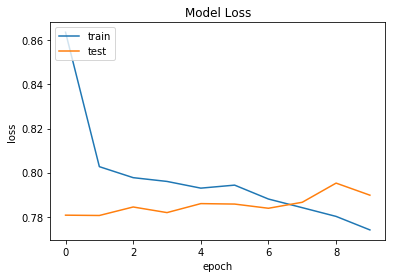

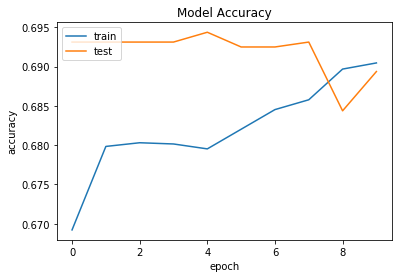

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Save the model

In [13]:
import pickle

filename = 'model_text.sav'
pickle.dump(model, open(filename, 'wb'))